# **Attention Res-Unet with Guided Decoder (ARU-GD)**
---

Here is the code implementation of the proposed model ***Attention Res-Unet with Guided Decoder (ARU-GD)*** as described in the paper **"Attention Res-UNet with Guided Decoder for Semantic Segmentation of Brain Tumors"**. 

The automatic segmentation of brain tumors in Magnetic Resonance Imaging (MRI) plays a major role in accurate diagnosis and treatment planning. The present study proposes a new deep learning generator architecture called Attention Res-UNet with Guided Decoder (ARU-GD) for the segmentation of brain tumors. The proposed generator architecture have the capability to explicitly guide the learning process of each decoder layer. The individual loss function to each decoder layer helps to supervise the learning process of each layer in the decoder and thereby enables them to generate better feature maps. The attention gates in the generator focuses on the activations of relevant information instead of allowing all information to pass through the skip connections in the Res-UNet. Our model performed well in comparison to the baseline models i.e. UNet, Res-UNet, and Res-UNet with attention gates. The proposed ARU-GD also outperforms other popular deep learning models like VGG-Net, MobileNet, QuickNAT, DenseNet and XceptionNet. The proposed ARU-GD has achieved Dice Scores of 0.911, 0.876 and 0.801 and mean IoU of 0.838, 0.781 and 0.668 on the whole tumor, tumor core and enhancing tumor region respectively on unseen test data.







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

import keras
from keras.layers import Conv2D, Activation, Input, Dropout, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, multiply, Add, LeakyReLU
from keras.layers.normalization import BatchNormalization 
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import *
from keras import regularizers
from keras import backend as K
from keras.models import load_model
from keras.layers.core import Lambda

In [ ]:
pip install SimpleITK

In [ ]:
import SimpleITK as sitk

# Data Preprocessing and creating Pickle files
You only need to run these sections once for creating the pickle files after data preprocessing, so that next time loading data is much faster and it takes up less storage, and we don't have to perform the data preprocessing steps again.

All the flair images of each patient have been put in one folder called "flair", and same has been done for T1, T1ce and T2 images. 

The ground truths of each patient has been put in the folder called "seg".

These folders (flair, t1, t1ce, t2 and seg) are placed inside the **HGG** folder.

The pickle files are being saved inside the folder called "Colab Notebooks" where the program files are present.

In [ ]:
flair_path = glob.glob('/content/drive/My Drive/HGG/flair/*')
seg_path   = glob.glob('/content/drive/My Drive/HGG/seg/*')
t1_path    = glob.glob('/content/drive/My Drive/HGG/t1/*')
t1ce_path  = glob.glob('/content/drive/My Drive/HGG/t1ce/*')
t2_path    = glob.glob('/content/drive/My Drive/HGG/t2/*')

In [ ]:
print(len(flair_path))

In [ ]:
X_flair=[]
for i in range(len(flair_path)):
    a = sitk.ReadImage(flair_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_flair.append((a[50+2*j,:,:]))
print(np.shape(X_flair))

In [ ]:
X_flair = np.asarray(X_flair).astype(np.float32)

In [ ]:
mean = X_flair.mean()
std = X_flair.std()
X_flair = (X_flair - mean)/(std + 1e-8)
np.min(X_flair), np.max(X_flair)

In [ ]:
pickle_out = open('/content/drive/My Drive/Colab Notebooks/flair_25.pickle', 'wb')
pickle.dump(X_flair, pickle_out)
pickle_out.close()
del X_flair

In [ ]:
X_t1=[]
for i in range(len(t1_path)):
    a = sitk.ReadImage(t1_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_t1.append((a[50+2*j,:,:]))
print(np.shape(X_t1))

In [ ]:
X_t1 = np.asarray(X_t1).astype(np.float32)

In [ ]:
mean = X_t1.mean()
std = X_t1.std()
X_t1 = (X_t1 - mean)/(std + 1e-8)
np.min(X_t1), np.max(X_t1)

In [ ]:
pickle_out = open('/content/drive/My Drive/Colab Notebooks/t1_25.pickle', 'wb')
pickle.dump(X_t1, pickle_out)
pickle_out.close()
del X_t1

In [ ]:
X_t1ce=[]
for i in range(len(t1ce_path)):
    a = sitk.ReadImage(t1ce_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_t1ce.append((a[50+2*j,:,:]))
print(np.shape(X_t1ce))

In [ ]:
X_t1ce = np.asarray(X_t1ce).astype(np.float32)

In [ ]:
mean = X_t1ce.mean()
std = X_t1ce.std()
X_t1ce = (X_t1ce - mean)/(std + 1e-8)
np.min(X_t1ce), np.max(X_t1ce)

In [ ]:
pickle_out = open('/content/drive/My Drive/Colab Notebooks/t1ce_25.pickle', 'wb')
pickle.dump(X_t1ce, pickle_out)
pickle_out.close()
del X_t1ce

In [ ]:
X_t2=[]
for i in range(len(t2_path)):
    a = sitk.ReadImage(t2_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_t2.append((a[50+2*j,:,:]))
print(np.shape(X_t2))

In [ ]:
X_t2 = np.asarray(X_t2).astype(np.float32)

In [ ]:
mean = X_t2.mean()
std = X_t2.std()
X_t2 = (X_t2 - mean)/(std + 1e-8)
np.min(X_t2), np.max(X_t2)

In [ ]:
pickle_out = open('/content/drive/My Drive/Colab Notebooks/t2_25.pickle', 'wb')
pickle.dump(X_t2, pickle_out)
pickle_out.close()
del X_t2

In [ ]:
X_seg=[]
for i in range(len(seg_path)):
    a = sitk.ReadImage(seg_path[i])
    a = sitk.GetArrayFromImage(a)
    for j in range(25):
        X_seg.append((a[50+2*j,:,:]))
print(np.shape(X_seg))

In [ ]:
X_seg = np.asarray(X_seg).astype(np.float32)

In [ ]:
pickle_out = open('/content/drive/My Drive/Colab Notebooks/gt_25.pickle', 'wb')
pickle.dump(X_seg, pickle_out)
pickle_out.close()
del X_seg

# Loading Data from Pickle files

In this section, we load the data from the pickle files saved previously. 

In [ ]:
pickle_in = open('/content/drive/My Drive/Colab Notebooks/flair_25.pickle', 'rb')
X_flair = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
pickle_in = open('/content/drive/My Drive/Colab Notebooks/t1_25.pickle', 'rb')
X_t1 = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
pickle_in = open('/content/drive/My Drive/Colab Notebooks/t1ce_25.pickle', 'rb')
X_t1ce = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
pickle_in = open('/content/drive/My Drive/Colab Notebooks/t2_25.pickle', 'rb')
X_t2 = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
print(X_flair.shape[0])

6475


In [ ]:
data = np.zeros((X_flair.shape[0],240,240,4))
for i in range(data.shape[0]):
    data[i,:,:,0] = X_flair[i,:,:]
    data[i,:,:,1] = X_t1[i,:,:]
    data[i,:,:,2] = X_t1ce[i,:,:]
    data[i,:,:,3] = X_t2[i,:,:]

In [ ]:
print(np.shape(data))

(6475, 240, 240, 4)


In [ ]:
del X_flair
del X_t1
del X_t2
del X_t1ce

In [ ]:
pickle_in = open('/content/drive/My Drive/Colab Notebooks/gt_25.pickle', 'rb')
X_seg = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
print(np.unique(X_seg))

[0. 1. 2. 4.]


In [ ]:
X_seg[X_seg == 4] = 3

In [ ]:
print(np.unique(X_seg))

[0. 1. 2. 3.]


In [ ]:
print(X_seg.shape)

(6475, 240, 240)


In [ ]:
gt = to_categorical(X_seg, num_classes=None)
print(gt.shape)

(6475, 240, 240, 4)


In [ ]:
print(data.shape)
print(gt.shape)

(6475, 240, 240, 4)
(6475, 240, 240, 4)


In [ ]:
del X_seg

In [ ]:
X_train = data[:4700]
X_valid = data[4700:5475]
X_test  = data[5475:]

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

In [ ]:
Y_train = gt[:4700]
Y_valid = gt[4700:5475]
Y_test  = gt[5475:]

In [ ]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_datagen = ImageDataGenerator(rotation_range=10,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)
mask_datagen = ImageDataGenerator(rotation_range=10,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)

In [ ]:
seed = 1

In [ ]:
image_generator = image_datagen.flow(X_train, batch_size=8, seed=seed)

mask_generator = mask_datagen.flow(Y_train, batch_size=8, seed=seed)

In [ ]:
def train_generator(image_generator, mask_generator):
    while True:
        image_next = image_generator.next()
        mask_next  = mask_generator.next()
        yield image_next, [mask_next, mask_next, mask_next, mask_next]

# ARU-GD model:

In [ ]:
batch_size = 8
image_size = 240
epochs = 100

In [ ]:
# Attention module block

def attention_block2d(x, g, inter_channel, i, data_format='channels_last'):

    theta_x = Conv2D(inter_channel, [2, 2], strides=[2, 2], data_format=data_format, kernel_regularizer=regularizers.l2(1e-5))(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1],dilation_rate=i, data_format=data_format, kernel_regularizer=regularizers.l2(1e-5))(g)

    f = LeakyReLU(alpha=0.2)(Add([theta_x, phi_g]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1],dilation_rate=i, data_format=data_format, kernel_regularizer=regularizers.l2(1e-5))(f)

    sigm_psi_f = Activation(activation='sigmoid')(psi_f)

    rate = UpSampling2D(size=[2, 2])(sigm_psi_f)

    att_x = multiply([x, rate])

    return att_x

In [ ]:
def res_block(x, nb_filters, strides, i):
    
    res_path = BatchNormalization()(x)
    res_path = LeakyReLU(alpha=0.2)(res_path)
    pool = MaxPooling2D(pool_size=(2, 2))(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same',dilation_rate=i, strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(pool)
    res_path = BatchNormalization()(res_path)
    res_path = LeakyReLU(alpha=0.2)(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', dilation_rate=i,strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1),dilation_rate=i, strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(pool)
    shortcut = BatchNormalization()(shortcut)

    res_path = Add()([shortcut, res_path])
    return res_path


In [ ]:
def encoder(x):
    to_decoder = []
    
    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same',dilation_rate=(1,1), strides=(1, 1), kernel_regularizer=regularizers.l2(1e-5))(x)
    main_path = BatchNormalization()(main_path)
    main_path = LeakyReLU(alpha=0.2)(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same',dilation_rate=(1,1),strides=(1, 1), kernel_regularizer=regularizers.l2(1e-5))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1),dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = Add()([shortcut, main_path])
    
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)],(1,1))
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)],(2,2))
    to_decoder.append(main_path)

    main_path = res_block(main_path, [512, 512], [(2, 2), (1, 1)],(4,4))
    to_decoder.append(main_path)

    return to_decoder

In [ ]:
def res_block_decoder(x, nb_filters, strides,i):
    
    res_path = BatchNormalization()(x)
    res_path = LeakyReLU(alpha=0.2)(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', dilation_rate=i, strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = LeakyReLU(alpha=0.2)(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', dilation_rate=i, strides=strides[1], kernel_regularizer=regularizers.l2(1e-5))(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[1], dilation_rate=i, kernel_regularizer=regularizers.l2(1e-5))(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = Add()([shortcut, res_path])

    return res_path


In [ ]:
def decoder(x, from_encoder):
    
    # Layer 4
    attention_path1 = attention_block2d(from_encoder[3], x, 256, (1,1), data_format='channels_last')
    
    main_path1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1),kernel_regularizer=regularizers.l2(1e-5))(x)
    main_path1 = Concatenate()([main_path1,attention_path1])
    main_path1 = res_block_decoder(main_path1, [512, 512], [(1, 1), (1, 1)],(4,4))
    
    hc1 = three_times_sample(main_path1)
    out_1 = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='out_1')(hc1)


    # Layer 3
    attention_path2 = attention_block2d(from_encoder[2],main_path1 ,128,(1,1),data_format='channels_last')

    main_path2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), dilation_rate=(1,1), padding='same', kernel_regularizer=regularizers.l2(1e-5))(main_path1)
    main_path2 = Concatenate()([main_path2,attention_path2])
    main_path2 = res_block_decoder(main_path2, [256, 256], [(1, 1), (1, 1)],(2,2))
    
    hc2 = two_times_sample(main_path2)
    out_2 = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='out_2')(hc2)


    # Layer 2
    attention_path3 = attention_block2d(from_encoder[1],main_path2,64,(1,1),data_format='channels_last')

    main_path3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (main_path2) 
    main_path3 = Concatenate()([main_path3,attention_path3])
    main_path3 = res_block_decoder(main_path3, [128, 128], [(1, 1), (1, 1)],(1,1))
    
    hc3 = one_time_sample(main_path3)
    out_3 = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='out_3')(hc3)


    # Layer 1
    attention_path4 = attention_block2d(from_encoder[0],main_path3,32,(1,1),data_format='channels_last')

    main_path4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1),kernel_regularizer=regularizers.l2(1e-5)) (main_path3) 
    main_path4 = Concatenate()([main_path4,attention_path4])
    main_path4 = res_block_decoder(main_path4, [64, 64], [(1, 1), (1, 1)],(1,1))

    return main_path4, out_3, out_2, out_1

In [ ]:
def three_times_sample(main_path):
    hyper1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1),kernel_regularizer=regularizers.l2(1e-5)) (main_path)
    hyper2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (hyper1)
    hyper3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (hyper2)
    return hyper3


def two_times_sample(main_path):
    hyper1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5))(main_path)
    hyper2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1) ,kernel_regularizer=regularizers.l2(1e-5))(hyper1)
    return hyper2


def one_time_sample(main_path):
    hyper1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',dilation_rate=(1,1), kernel_regularizer=regularizers.l2(1e-5)) (main_path)
    return hyper1


In [ ]:
def join_all_the_layers(hc1,hc2,hc3,hc4):

    combine1      =  Concatenate()([hc1,hc2])
    combine2      =  Concatenate()([hc3,hc4])
    combine_final =  Concatenate()([combine1,combine2])

    return combine_final


In [ ]:
def aru_gd(input_shape):
    inputs = Input(shape=input_shape)
    
    to_decoder = encoder(inputs)

    path = res_block(to_decoder[3], [1024, 1024], [(2, 2), (1, 1)],(8,8))

    final_out, out_3, out_2, out_1 = decoder(path, from_encoder=to_decoder)

    final_out = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax', name='final_output')(final_out)

    return Model(inputs=inputs, outputs= [final_out, out_3, out_2, out_1])

# Loss Functions : 




In [ ]:
def dice_coef_0(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,0])
    y_pred_f = K.flatten(y_pred[:,:,:,0])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_1(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_2(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_3(y_true, y_pred,smooth=0.000001):
    y_true_f = K.flatten(y_true[:,:,:,3])
    y_pred_f = K.flatten(y_pred[:,:,:,3])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



In [ ]:
def dice_score(y_true, y_pred):
    d0 = dice_coef_0(y_true, y_pred,smooth=0.000001)
    d1 = dice_coef_1(y_true, y_pred,smooth=0.000001)
    d2 = dice_coef_2(y_true, y_pred,smooth=0.000001)
    d3 = dice_coef_3(y_true, y_pred,smooth=0.000001)

    dice_mean = (d0+d1+d2+d3)/4
    return dice_mean

def weighted_dice_score(y_true, y_pred):
    ds0 = dice_coef_0(y_true, y_pred,smooth=0.000001)
    ds1 = dice_coef_1(y_true, y_pred,smooth=0.000001)
    ds2 = dice_coef_2(y_true, y_pred,smooth=0.000001)
    ds3 = dice_coef_3(y_true, y_pred,smooth=0.000001)

    weighted_dice_mean = (ds0+(5*ds1)+(2*ds2)+(4*ds3))/12
    return weighted_dice_mean


In [ ]:
def dice_loss(y_true, y_pred):
    return 1-dice_score(y_true, y_pred)


def weighted_dice_loss(y_true, y_pred):
    return 1-weighted_dice_score(y_true, y_pred)

In [ ]:
def weighted_log_loss(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # weights are assigned in this order : normal,necrotic,edema,enhancing 
    weights=np.array([1,5,2,4])
    weights = K.variable(weights)
    loss = y_true * K.log(y_pred) * weights
    loss = K.mean(-K.sum(loss, -1))
    return loss

In [ ]:
def gen_dice_loss(y_true, y_pred):
    return weighted_dice_loss(y_true, y_pred)+weighted_log_loss(y_true,y_pred)

In [ ]:
input_shape = (240,240,4)
losses = {
    'final_output':gen_dice_loss, 
    'out_3':gen_dice_loss, 
    'out_2':gen_dice_loss, 
    'out_1':gen_dice_loss,  
}
lossWeights = {"final_output": 0.5, "out_3": 0.125, "out_2": 0.125, "out_1": 0.125}

# Training a new model :

If you want to train a new model using this architecture, then skip the cell containing **load_model** after this. Directly compile the model and train it.

In [ ]:
model = aru_gd(input_shape)

# Loading previously trained model :

After loading the previously trained model, compile it and then you can use it to generate predictions.

In [ ]:
model_path = 
model = load_model('/content/drive/My Drive/Colab Notebooks/Aru-gd.h5', compile=False)

# Compile :

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss= losses, loss_weights=lossWeights,  
              metrics=[dice_score])
model.summary()

# Training the model :

In [ ]:
# checkpoint
filepath="/content/drive/My Drive/Colab Notebooks/ARUGD_training_checkpoint.h5"
#earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
checkpoint = ModelCheckpoint(filepath, save_best_only=False, monitor='loss',verbose=1, mode='min', period=1)

In [ ]:
history=model.fit_generator(train_generator(image_generator, mask_generator),
	                  validation_data=(X_valid, [Y_valid, Y_valid, Y_valid, Y_valid]),
	                  steps_per_epoch=len(X_train) // batch_size,
	                  epochs=epochs, verbose=1, shuffle=True, 
										callbacks=[checkpoint]
                    )


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Aru-gd_model1.h5', include_optimizer=True)

# Generating Predictions :

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(np.shape(pred))

In [ ]:
pred = np.argmax(pred, axis=-1)

In [ ]:
#To choose the output from the final layer only, we take the slices in the 0th index.
predicted_images = np.reshape(pred[0,:,:,:], (1000,240,240))

In [ ]:
GT = np.argmax(Y_test, axis=-1)
print(GT.shape)

In [ ]:
predicted_images[predicted_images==3] = 4
GT[GT==3] = 4

# Metrics :

In [ ]:
def iou_coef(s,g):
    num = np.sum(np.multiply(s,g))
    denom=s.sum() + g.sum() - num
    if denom==0:
        return 1
    else:
        return num/denom

In [ ]:
def iou_whole(pred, orig_label):
    #computes dice for the whole tumor
    return iou_coef(pred>0,orig_label>0)


def iou_en(pred, orig_label):
    #computes dice for enhancing region
    return iou_coef(pred==4,orig_label==4)


def iou_core(pred, orig_label):
    #computes dice for core region
    seg_=np.copy(pred)
    ground_=np.copy(orig_label)
    seg_[seg_==2]=0
    ground_[ground_==2]=0
    return iou_coef(seg_>0,ground_>0)

In [ ]:
predicted_images = predicted_images.astype(np.int32)
GT = GT.astype(np.int32)

iou_complete  = iou_whole(predicted_images,GT)
iou_enhancing = iou_en(predicted_images,GT)
iou_core      = iou_core(predicted_images,GT)

print("iou complete tumor score : {:0.4f}".format(iou_complete))
print("iou core tumor score (tt sauf vert): {:0.4f}".format(iou_core))
print("iou enhancing tumor score (jaune):{:0.4f} ".format(iou_enhancing))

In [ ]:
### METRICS

def binary_dice3d(s,g):
    #dice score of two 3D volumes
    num=np.sum(np.multiply(s, g))
    denom=s.sum() + g.sum() 
    if denom==0:
        return 1
    else:
        return  2.0*num/denom



def DSC_whole(pred, orig_label):
    #computes dice for the whole tumor
    return binary_dice3d(pred>0,orig_label>0)


def DSC_en(pred, orig_label):
    #computes dice for enhancing region
    return binary_dice3d(pred==4,orig_label==4)


def DSC_core(pred, orig_label):
    #computes dice for core region
    seg_=np.copy(pred)
    ground_=np.copy(orig_label)
    seg_[seg_==2]=0
    ground_[ground_==2]=0
    return binary_dice3d(seg_>0,ground_>0)

In [ ]:
Dice_complete=DSC_whole(predicted_images,GT)
Dice_enhancing=DSC_en(predicted_images,GT)
Dice_core=DSC_core(predicted_images,GT)

print("Dice complete tumor score : {:0.4f}".format(Dice_complete))
print("Dice core tumor score (tt sauf vert): {:0.4f}".format(Dice_core))
print("Dice enhancing tumor score (jaune):{:0.4f} ".format(Dice_enhancing))

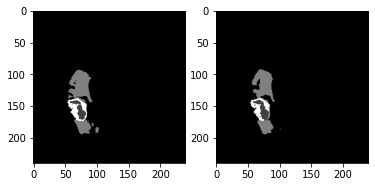

In [ ]:
plt.figure(figsize=[5,5])
%matplotlib inline

plt.subplot(121)
curr_img = np.reshape(GT[350],(240,240))
plt.imshow(curr_img, cmap='gray')


plt.subplot(122)
curr_img = np.reshape(predicted_images[350], (240,240))
plt.imshow(curr_img, cmap='gray')